In [1]:
import pandas as pd
import numpy as np
import requests 
import matplotlib.pyplot as plt
import datetime 

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

from fbprophet import Prophet 
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric


In [2]:
## Import and clean data (copied from Daniela's script)

r = requests.get("https://api-pc6dbtrtla-uc.a.run.app/API/timeseries/usa")
response_dict = r.json()
df = pd.DataFrame.from_dict(response_dict)
df = df.rename(columns={'Total Results as of Date': 'Date'})
df['Day'] = (np.array([i for i in range (len(df.Date))]).reshape(-1,1))+1
df['Date'] = pd.to_datetime(df['Date']).dt.date

df['NewCases_1'] = df['Cases'] - df['Cases'].shift(1)
df['NewCases_7'] = df['Cases'] - df['Cases'].shift(7)
df['NewCases_14'] = df['Cases'] - df['Cases'].shift(14)

df['NewDeaths_1'] = df['Deaths'] - df['Deaths'].shift(1)
df['NewDeaths_7'] = df['Deaths'] - df['Deaths'].shift(7)
df['NewDeaths_14'] = df['Deaths'] - df['Deaths'].shift(14)

df.tail(14)

,ISO3,Country,Date,Cases,Deaths,Recovered,Day,NewCases_1,NewCases_7,NewCases_14,NewDeaths_1,NewDeaths_7,NewDeaths_14
104,USA,US,2020-05-05,1204351.0,71064.0,189791.0,105,23976.0,191769.0,392486.0,2142.0,12709.0,25978.0
105,USA,US,2020-05-06,1229331.0,73455.0,189910.0,106,24980.0,189422.0,388980.0,2391.0,12488.0,26043.0
106,USA,US,2020-05-07,1257023.0,75662.0,195036.0,107,27692.0,187599.0,387853.0,2207.0,12666.0,25938.0
107,USA,US,2020-05-08,1283929.0,77180.0,198993.0,108,26906.0,180468.0,378571.0,1518.0,12237.0,25687.0
108,USA,US,2020-05-09,1309550.0,78795.0,212534.0,109,25621.0,177011.0,371396.0,1615.0,12426.0,25040.0
109,USA,US,2020-05-10,1329260.0,79526.0,216169.0,110,19710.0,171220.0,363475.0,731.0,11844.0,24645.0
110,USA,US,2020-05-11,1347881.0,80682.0,232733.0,111,18621.0,167506.0,359684.0,1156.0,11760.0,24463.0
111,USA,US,2020-05-12,1369376.0,82356.0,230287.0,112,21495.0,165025.0,356794.0,1674.0,11292.0,24001.0
112,USA,US,2020-05-13,1390406.0,84119.0,243430.0,113,21030.0,161075.0,350497.0,1763.0,10664.0,23152.0
113,USA,US,2020-05-14,1417774.0,85898.0,246414.0,114,27368.0,160751.0,348350.0,1779.0,10236.0,22902.0


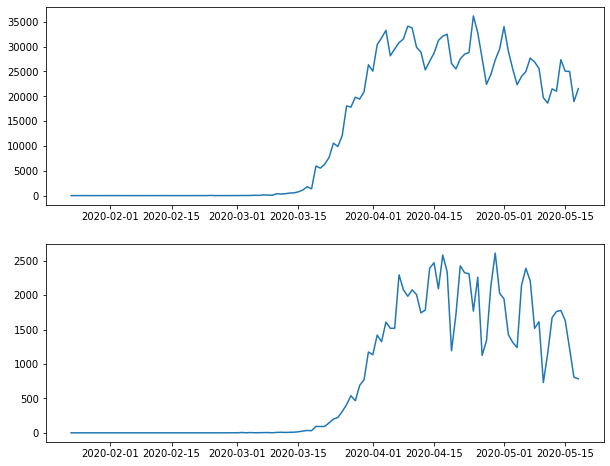

In [3]:
# Entire data from Jan 22th

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))
ax1.plot(df["Date"], df["NewCases_1"])
ax2.plot(df["Date"], df["NewDeaths_1"])

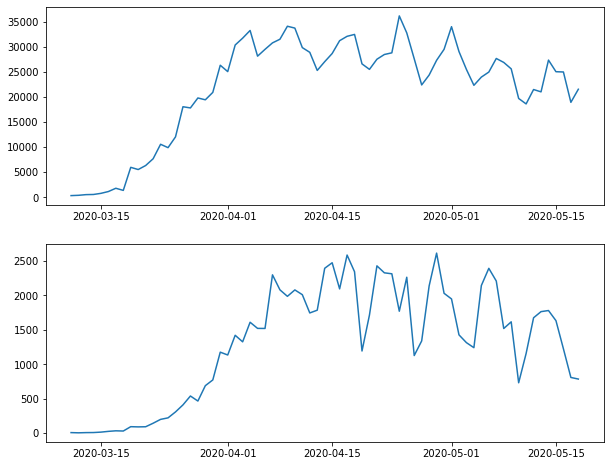

In [4]:
# Data since 3/11/20 (when WHO declared pandemic) 

df1 = df.loc[df["Date"]>=datetime.date(2020,3,11)]

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))
ax1.plot(df1["Date"], df1["NewCases_1"])
ax2.plot(df1["Date"], df1["NewDeaths_1"])

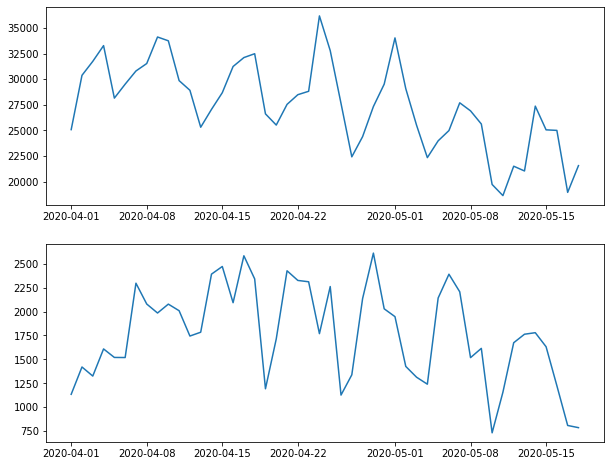

In [5]:
# Data since confirmed cases >= 20000 (since 4/1/20)

df2 = df.loc[df["Cases"]>=200_000]

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))
ax1.plot(df2["Date"], df2["NewCases_1"])
ax2.plot(df2["Date"], df2["NewDeaths_1"])

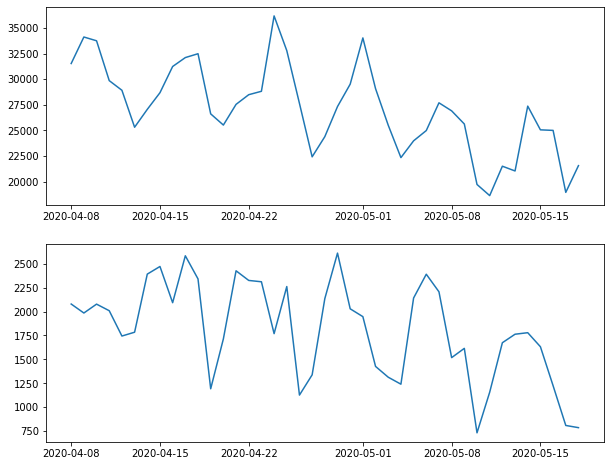

In [6]:
# Data since 4/8/20

df3 = df.loc[df["Date"]>=datetime.date(2020,4,8)]

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))
ax1.plot(df3["Date"], df3["NewCases_1"])
ax2.plot(df3["Date"], df3["NewDeaths_1"])

In [7]:
df.shape

(118, 13)

In [8]:
df1.shape

(69, 13)

In [9]:
df2.shape

(48, 13)

In [10]:
df3.shape

(41, 13)

In [11]:
# Linear model predicting confirmed cases 

X = df2[["Day"]]
y = df2["NewCases_1"]

tscv = TimeSeriesSplit(n_splits=5)

lr = LinearRegression()
cross_validate(lr, X, y, cv=tscv, scoring="neg_mean_squared_error")["test_score"].mean()

-17442521.283374816

In [12]:
# Predict future confirmed cases

lr.fit(X, y)
lr.predict([[120]])

array([22624.615791])

In [13]:
# Linear model predicting deaths

X = df3[["Day"]]
y = df3["NewDeaths_1"]

tscv = TimeSeriesSplit(n_splits=5)

lr = LinearRegression()
cross_validate(lr, X, y, cv=tscv, scoring="neg_mean_squared_error")["test_score"].mean()

-309216.246181795

In [14]:
# Predict future deaths

lr.fit(X, y)
lr.predict([[120]])

array([1308.99163763])

In [15]:
### Prophet models ###

In [16]:
df_prophet1 = df1[["Date", "NewCases_1"]].rename(columns={"Date": "ds", "NewCases_1": "y"})
df_prophet2 = df2[["Date", "NewCases_1"]].rename(columns={"Date": "ds", "NewCases_1": "y"})

In [17]:
## Models for Confirmed Cases

# Model1: Starting date 3/11/20 
max_cases = df_prophet1["y"].max()
df_prophet1['cap'] = max_cases
df_prophet1

,ds,y,cap
49,2020-03-11,322.0,36188.0
50,2020-03-12,382.0,36188.0
51,2020-03-13,516.0,36188.0
52,2020-03-14,548.0,36188.0
53,2020-03-15,772.0,36188.0
...,...,...,...
113,2020-05-14,27368.0,36188.0
114,2020-05-15,25050.0,36188.0
115,2020-05-16,24996.0,36188.0
116,2020-05-17,18937.0,36188.0


In [18]:
prophet = Prophet(growth='logistic')
prophet.fit(df_prophet1)

future = prophet.make_future_dataframe(periods=10)
future['cap'] = max_cases

forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
69,2020-05-19,34100.194670,25138.446197,43093.496821
70,2020-05-20,33820.322118,24579.296437,42485.282280
71,2020-05-21,36792.384316,27574.761566,46157.568590
72,2020-05-22,37502.706454,27746.713059,46535.271702
73,2020-05-23,36315.966781,27609.623255,45695.551599
74,2020-05-24,32867.940546,23191.454178,41782.936446
75,2020-05-25,32018.553492,22310.241933,41513.540920
76,2020-05-26,34669.538604,24761.971918,44092.557786
77,2020-05-27,34358.115255,25017.912149,44280.942153
78,2020-05-28,37300.240539,27746.159050,46859.729407


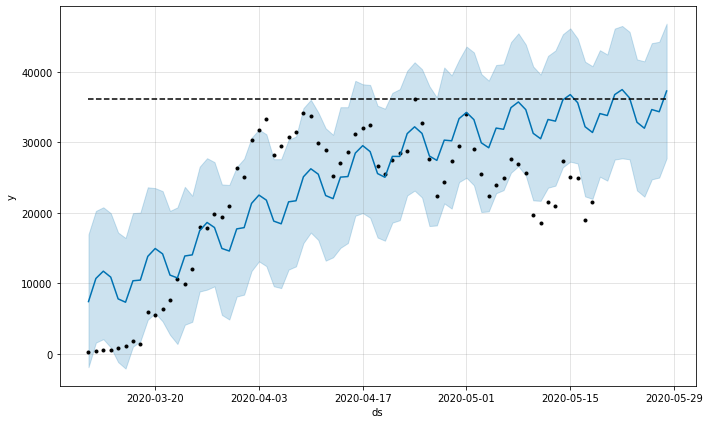

In [19]:
fig_forecast = prophet.plot(forecast)

In [20]:
df_cv = cross_validation(prophet, initial='50 days', period='4 days', horizon='7 days')

df_cv

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-03 00:00:00 and 2020-05-11 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-04,34121.636020,27859.462623,40303.839608,22335.0,2020-05-03
1,2020-05-05,35243.522826,28865.789853,41949.075422,23976.0,2020-05-03
2,2020-05-06,35367.474966,28976.490890,41396.674209,24980.0,2020-05-03
3,2020-05-07,37721.406878,31440.304751,43807.766627,27692.0,2020-05-03
4,2020-05-08,38771.147679,32656.033786,44829.393520,26906.0,2020-05-03
5,2020-05-09,37232.789408,30362.552464,43734.863998,25621.0,2020-05-03
6,2020-05-10,34200.916469,27714.193969,40201.647759,19710.0,2020-05-03
7,2020-05-08,39468.787717,32230.740215,46572.578689,26906.0,2020-05-07
8,2020-05-09,37946.478532,31060.556904,45131.835836,25621.0,2020-05-07
9,2020-05-10,34930.452785,27558.867999,41440.038899,19710.0,2020-05-07


In [21]:
df_p = performance_metrics(df_cv)

df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.648394e+08,12838.978481,12804.161540,0.549627,0.527720,0.0
1,2 days,1.638457e+08,12800.221970,12725.318548,0.548152,0.481069,0.0
2,3 days,1.511106e+08,12292.706847,12091.411594,0.525929,0.415832,0.0
3,4 days,1.711407e+08,13082.076382,12915.456379,0.571120,0.553209,0.0
4,5 days,1.562745e+08,12500.980257,12489.483815,0.517041,0.497254,0.0
5,6 days,1.858024e+08,13630.933809,13551.585267,0.637979,0.659945,0.0
6,7 days,1.443829e+08,12015.943970,11860.688757,0.538626,0.517628,0.0


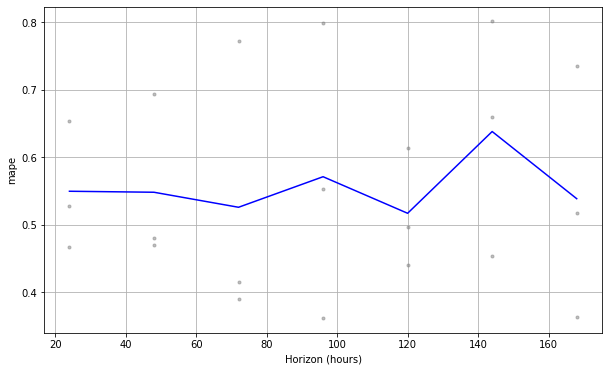

In [22]:
fig_test = plot_cross_validation_metric(df_cv, metric='mape')

In [23]:
# Model2: Starting date 4/1/20
df_prophet2 

,ds,y
70,2020-04-01,25070.0
71,2020-04-02,30380.0
72,2020-04-03,31745.0
73,2020-04-04,33283.0
74,2020-04-05,28152.0
75,2020-04-06,29515.0
76,2020-04-07,30804.0
77,2020-04-08,31533.0
78,2020-04-09,34126.0
79,2020-04-10,33755.0


In [24]:
prophet = Prophet()
prophet.fit(df_prophet2)

future = prophet.make_future_dataframe(periods=10)
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
48,2020-05-19,20280.101498,17919.905623,22493.202346
49,2020-05-20,20564.595916,18142.113561,22912.030419
50,2020-05-21,23621.015012,21484.458445,25922.328062
51,2020-05-22,25051.354132,22743.415665,27458.736940
52,2020-05-23,23292.869549,20915.239939,25503.674057
53,2020-05-24,18557.376154,16235.841821,20733.803840
54,2020-05-25,17030.998275,14965.685959,19266.438384
55,2020-05-26,18429.759747,16108.930492,20843.247464
56,2020-05-27,18714.254165,16452.121963,20996.568483
57,2020-05-28,21770.673262,19632.443145,23948.942184


In [25]:
### MSE calculation for the last two weeks of data (for comparison with ARIMA model) ###

prophet_yhat = forecast[['ds', 'yhat']].copy()
prophet_yhat["ds"] = pd.to_datetime(prophet_yhat["ds"]).dt.date
prophet_yhat = prophet_yhat.loc[prophet_yhat["ds"]>=datetime.date(2020,5,5)]
prophet_yhat = prophet_yhat.loc[prophet_yhat["ds"]<=datetime.date(2020,5,18)]

df_prophet2["ds"] = pd.to_datetime(df_prophet2["ds"]).dt.date
df_prophet2 = df_prophet2.loc[df_prophet2["ds"]>=datetime.date(2020,5,5)]
df_prophet2 = df_prophet2.loc[df_prophet2["ds"]<=datetime.date(2020,5,18)]

mean_squared_error(df_prophet2["y"], prophet_yhat["yhat"])

2539068.1687234393

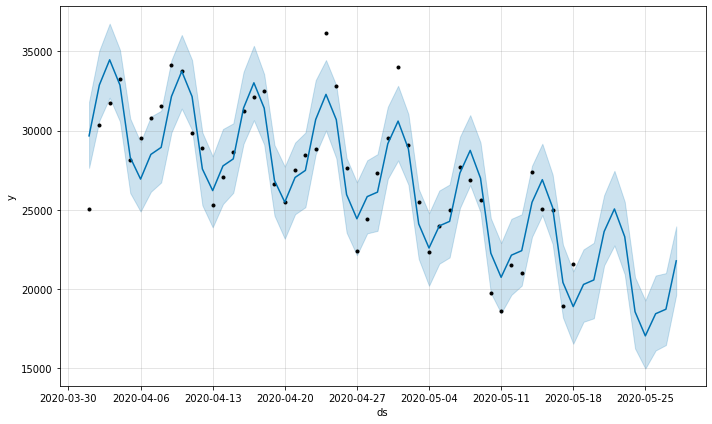

In [26]:
prophet_cases = prophet.plot(forecast)
prophet_cases.savefig("prophet_cases.png")

In [27]:
df_cv_cases = cross_validation(prophet, initial='30 days', period='4 days', horizon='7 days')

df_cv_cases

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-03 00:00:00 and 2020-05-11 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-04,24412.961265,22021.592204,26596.326469,22335.0,2020-05-03
1,2020-05-05,26169.971760,23853.922201,28403.753053,23976.0,2020-05-03
2,2020-05-06,26689.855764,24400.582263,29122.909097,24980.0,2020-05-03
3,2020-05-07,29286.599101,26947.854218,31567.818486,27692.0,2020-05-03
4,2020-05-08,32037.536874,29878.467598,34364.251252,26906.0,2020-05-03
5,2020-05-09,29971.774924,27571.411323,32241.231171,25621.0,2020-05-03
6,2020-05-10,25833.113792,23537.172431,27910.315439,19710.0,2020-05-03
7,2020-05-08,31430.499522,29194.515769,33607.541059,26906.0,2020-05-07
8,2020-05-09,29362.621057,27102.097481,31587.114831,25621.0,2020-05-07
9,2020-05-10,25221.686207,23091.425682,27457.207547,19710.0,2020-05-07


In [28]:
df_p_cases = performance_metrics(df_cv_cases)

df_p_cases

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,8.377124e+06,2894.326094,2395.856349,0.096139,0.093036,0.666667
1,2 days,6.978422e+06,2641.670287,2464.103395,0.102271,0.091507,0.666667
2,3 days,1.301470e+07,3607.589201,3205.916321,0.145214,0.087555,0.333333
3,4 days,8.148781e+06,2854.607006,2600.156556,0.121315,0.077943,0.666667
4,5 days,1.200650e+07,3465.039281,2767.942527,0.112636,0.144768,0.333333
5,6 days,1.277474e+07,3574.176363,3323.038839,0.148224,0.169813,0.333333
6,7 days,1.637509e+07,4046.614815,3312.070862,0.161119,0.157001,0.333333


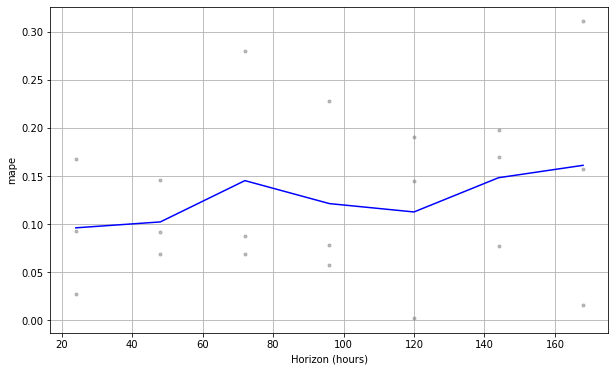

In [29]:
prophet_cases_test = plot_cross_validation_metric(df_cv_cases, metric='mape')
prophet_cases_test.savefig("prophet_cases_test.png")

In [30]:
# Model for Deaths
df_prophet3 = df3[["Date", "NewDeaths_1"]].rename(columns={"Date": "ds", "NewDeaths_1": "y"})
df_prophet3

,ds,y
77,2020-04-08,2079.0
78,2020-04-09,1985.0
79,2020-04-10,2078.0
80,2020-04-11,2009.0
81,2020-04-12,1744.0
82,2020-04-13,1784.0
83,2020-04-14,2392.0
84,2020-04-15,2472.0
85,2020-04-16,2093.0
86,2020-04-17,2584.0


In [31]:
prophet = Prophet()
prophet.fit(df_prophet3)

future = prophet.make_future_dataframe(periods=10)
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
41,2020-05-19,1753.038780,1456.186959,2038.071554
42,2020-05-20,1805.814208,1526.018794,2100.871131
43,2020-05-21,1599.486880,1305.143265,1872.782930
44,2020-05-22,1453.325440,1160.060898,1735.637072
45,2020-05-23,1344.996951,1043.953431,1614.415679
46,2020-05-24,684.345817,398.545876,985.945047
47,2020-05-25,868.178981,570.271573,1142.499262
48,2020-05-26,1619.313376,1334.546179,1904.046394
49,2020-05-27,1672.088804,1385.662533,1961.433670
50,2020-05-28,1465.761476,1147.852724,1760.698627


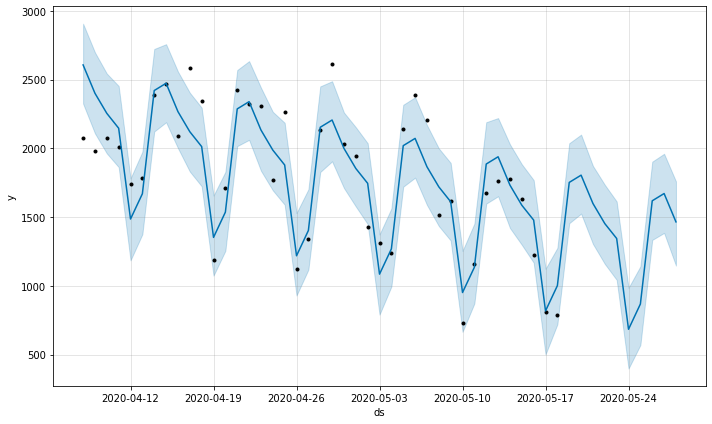

In [32]:
prophet_deaths = prophet.plot(forecast)
prophet_deaths.savefig("prophet_deaths.png")

In [33]:
df_cv_deaths = cross_validation(prophet, initial='23 days', period='4 days', horizon='7 days')

df_cv_deaths

INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-03 00:00:00 and 2020-05-11 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-04,1474.502860,1191.631023,1755.657207,1240.0,2020-05-03
1,2020-05-05,2180.813710,1881.942352,2481.671342,2142.0,2020-05-03
2,2020-05-06,2200.301532,1893.511707,2482.397132,2391.0,2020-05-03
3,2020-05-07,1932.790991,1640.102681,2216.324502,2207.0,2020-05-03
4,2020-05-08,1922.532757,1614.956650,2216.482490,1518.0,2020-05-03
5,2020-05-09,1837.775521,1549.579200,2135.641886,1615.0,2020-05-03
6,2020-05-10,1171.773082,881.656008,1469.605179,731.0,2020-05-03
7,2020-05-08,1951.496649,1659.700830,2209.919127,1518.0,2020-05-07
8,2020-05-09,1866.761010,1591.240460,2164.610405,1615.0,2020-05-07
9,2020-05-10,1200.870466,912.518827,1494.039969,731.0,2020-05-07


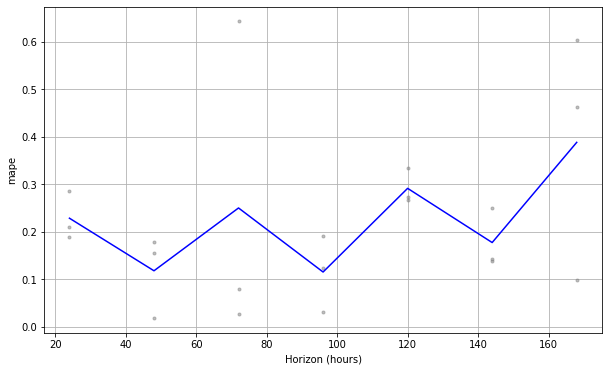

In [34]:
prophet_deaths_test = plot_cross_validation_metric(df_cv_deaths, metric='mape')
prophet_deaths_test.savefig("prophet_deaths_test.png")